<a href="https://colab.research.google.com/github/jmgang/SpoTwoFy-project-notebooks/blob/main/S3D3N9_Forecasting_Streams_of_Artist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 3 Activity - Forecasting the streams of your favorite artist

In [ ]:
# need to install earlier version of numpy for neuralprophet to work
!pip install git+https://github.com/ourownstory/neural_prophet.git numpy==1.23.5

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-vf9gy98e
  Running command git clone --filter=blob:none --quiet https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-vf9gy98e
  Resolved https://github.com/ourownstory/neural_prophet.git to commit f08dcf814034527577abe21ad0bdf28e27d4eb66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install neuralprophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels import datasets
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller

import plotly.express as px

In [ ]:
# Mount GDrive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set home directory
import os
home_dir = "drive/MyDrive/Eskwelabs/Sprint 3/data" # insert your home directory here
os.chdir(home_dir)

#### Data Preparation

In [ ]:
# read and process the charts dataset
df = pd.read_csv('ph_spotify_daily_charts.csv')
#transform date column into a datetime column
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,position,track_id,track_name,artist,streams
date,,,,,
2017-01-01,1,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,Bruno Mars,185236
2017-01-01,2,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,James Arthur,180552
2017-01-01,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,158720
2017-01-01,4,2rizacJSyD9S1IQUxUxnsK,All We Know,The Chainsmokers,130874
2017-01-01,5,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,Maroon 5,129656


In [ ]:
df

,position,track_id,track_name,artist,streams
date,,,,,
2017-01-01,1,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,Bruno Mars,185236
2017-01-01,2,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,James Arthur,180552
2017-01-01,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,158720
2017-01-01,4,2rizacJSyD9S1IQUxUxnsK,All We Know,The Chainsmokers,130874
2017-01-01,5,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,Maroon 5,129656
...,...,...,...,...,...
2023-10-15,196,6wdCelHrPh7UfliNjwRTUv,Leaves,Ben&Ben,80569
2023-10-15,197,3afkJSKX0EAMsJXTZnDXXJ,Strawberries & Cigarettes,Troye Sivan,80407
2023-10-15,198,4xqrdfXkTW4T0RauPLv3WA,Heather,Conan Gray,80398


#### Error definition

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def show_errors(y_true, y_pred):
    return pd.DataFrame({'RMSE': root_mean_squared_error(y_true,y_pred),\
                                            'MAE':mean_absolute_error(y_true,y_pred),\
                                            'MAPE': mean_absolute_percentage_error(y_true,y_pred)}, index=[0])

## Instructions

1. Pick one artist that had appeared in the Spotify charts from 2017-2023 and create a time series plot of their total daily streams.

2. Quickly describe the resulting time series plot, following the key points discussed in class.

3. *Forecasting*. Do the models discussed in class predict the streams of your chosen artist well?

   A. Identify a good training and testing period for your artist.
      - A good training period must be a year or more
      - A good testing period could be a month or a quarter
      - These periods must avoid long intervals with zero streams as much as possible
      
   B. Among the models discussed in class, pick 2-3 and plug in your training and testing data

   C. Assess the performance using the error metrics defined in the previous notebook.

3. Briefly share your output with the group

In [ ]:
# Replace 'top_200' with the actual name of the column containing position information
# Make sure you have already sorted the DataFrame by date and position
top_200_column = 'position'

# Group by artist and date and calculate the number of days an artist is in the top 200
artist_presence = df.groupby(['artist', df.index.date])[top_200_column].count()

# Count the total number of days in the dataset (this assumes daily data)
total_days = (df.index.max() - df.index.min()).days + 1

# Calculate the number of appearances for each artist
artist_appearances = artist_presence.groupby(level=0).count()

# Define a threshold (e.g., 80% of total days)
threshold = int(0.8 * total_days)

# Filter artists who have appeared in the top 200 for at least the threshold
consistent_artists = artist_appearances[artist_appearances >= threshold]

# Sort the artists by the number of appearances in descending order
sorted_artists = consistent_artists.sort_values(ascending=False)

# Get the top 20 most consistent artists
top_20_consistent_artists = sorted_artists.head(20)

# List the top 20 most consistent artists
print("Top 20 most consistent artists:")
print(top_20_consistent_artists.index)



Top 20 most consistent artists:
Index(['Hale', 'James Arthur', 'Bruno Mars', 'Silent Sanctuary',
       'Moira Dela Torre', 'Ariana Grande', 'Up Dharma Down', 'South Border',
       'Post Malone', 'Eraserheads', 'Parokya Ni Edgar', 'Lauv', 'Maroon 5',
       'LANY', 'Ed Sheeran', 'Ben&Ben', 'Sam Smith', 'Ne-Yo', 'IV Of Spades',
       'December Avenue'],
      dtype='object', name='artist')


## 1. Time series plot

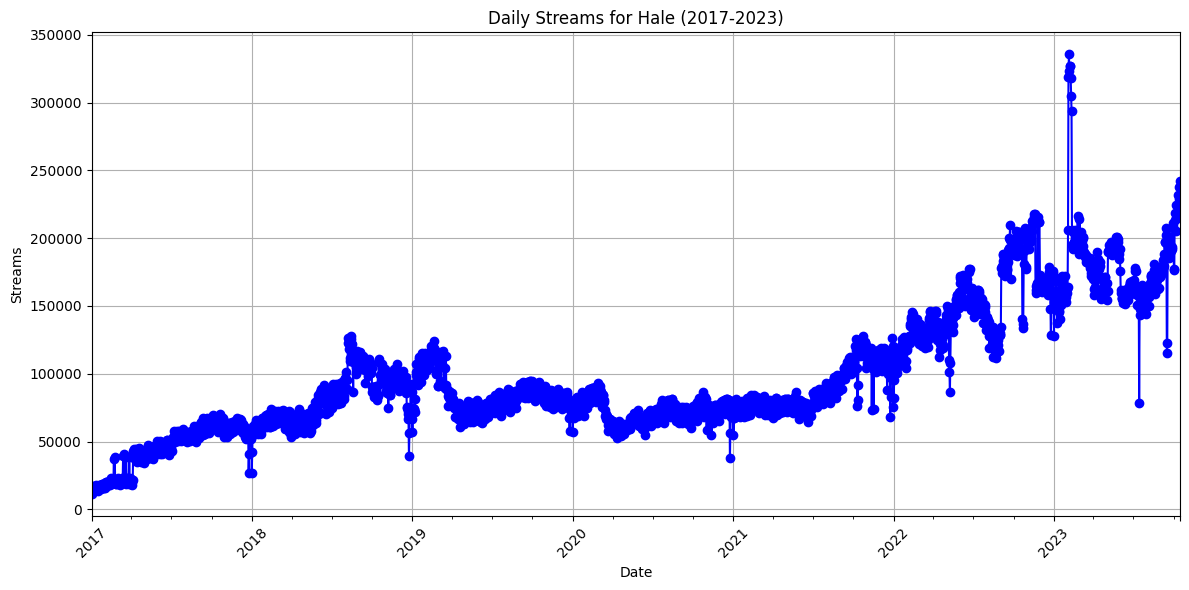

In [ ]:
artist_name = 'Hale'

# Filter the DataFrame to get data for the specific artist
artist_df = df[df['artist'] == artist_name]

# Resample the data by day and sum the streams for each day
artist_daily_streams = artist_df['streams'].resample('D').sum()

# Create a time series plot
plt.figure(figsize=(12, 6))
artist_daily_streams.plot(marker='o', linestyle='-', color='b')
plt.title(f'Daily Streams for {artist_name} (2017-2023)')
plt.xlabel('Date')
plt.ylabel('Streams')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
fig = px.line(artist_daily_streams, x=artist_daily_streams.index, y='streams', title=f'Daily Streams of {artist_name} Songs')

# Customize the layout of the plot
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Streams",
    legend_title="Song",
)

# Show the plot
fig.show()

In [ ]:
# choosing train/test set
train_start = '2017-01-01'
train_end = '2022-11-29'
test_start = '2022-11-30'
test_end = '2023-04-01'

## 2. Insights about the time series plot

Outliers? Sudden shifts?

In [ ]:
# Define the plot_ts_data function
def plot_ts_data(data, lower_bound, upper_bound, mark_outliers=True):
    fig, _ = plt.subplots(figsize=(13, 4))
    plt.plot(data)  # the line plot
    plt.fill_between(data.index, lower_bound, upper_bound, color='k', alpha=0.15)  # shade the region between bounds

    if mark_outliers:
        data_above_ub = data[data > upper_bound]  # show outliers beyond the upper bound
        data_below_lb = data[data < lower_bound]  # show outliers below the lower bound
        plt.plot(data_above_ub, color='C1', marker='o', ms=3, lw=0, label='Outliers Above UB')
        plt.plot(data_below_lb, color='C2', marker='o', ms=3, lw=0, label='Outliers Below LB')

    plt.legend()
    plt.ylabel('streams')

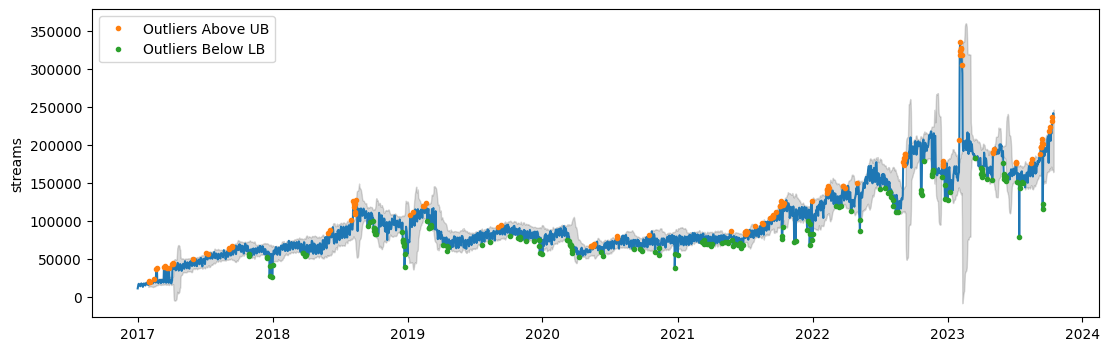

In [ ]:
# Set window size
BOUNDS_WINDOW = 30

# Use rolling in combination with quantile
p25_data = artist_daily_streams.rolling(BOUNDS_WINDOW).quantile(0.25)
mdn_data = artist_daily_streams.rolling(BOUNDS_WINDOW).quantile(0.5)
p75_data = artist_daily_streams.rolling(BOUNDS_WINDOW).quantile(0.75)

# Compute rolling IQR and bounds
IQR_data = p75_data - p25_data

# Subtract the median by the definition
lb_data = mdn_data - 1.5 * IQR_data
ub_data = mdn_data + 1.5 * IQR_data


# Plot the data with bounds and outliers
plot_ts_data(artist_daily_streams, lb_data, ub_data, mark_outliers=True)


Trends?

Cycles? Seasons?

<Figure size 2400x1600 with 0 Axes>

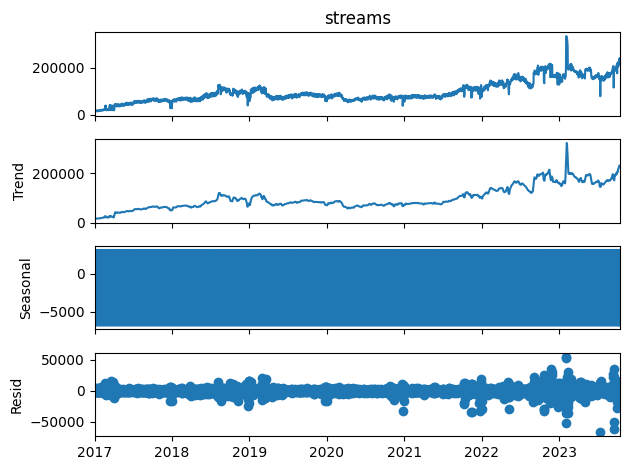

In [ ]:
res = sm.tsa.seasonal_decompose(artist_daily_streams) #statsmodels.tsa
plt.figure(figsize=(24, 16))
# resplot = res.plot()
res.plot()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for the original time series, trend, seasonal, and residual
fig.add_trace(go.Scatter(x=res.trend.index, y=res.trend, mode='lines', name='Trend'))
fig.add_trace(go.Scatter(x=res.seasonal.index, y=res.seasonal, mode='lines', name='Seasonal'))
fig.add_trace(go.Scatter(x=res.resid.index, y=res.resid, mode='lines', name='Residual'))

# Customize the layout
fig.update_layout(
    title="Seasonal Decomposition",
    xaxis_title="Date",
    yaxis_title="Value",
)

# Show the Plotly figure
fig.show()

## 3. Time series forecasting

<Axes: xlabel='date'>

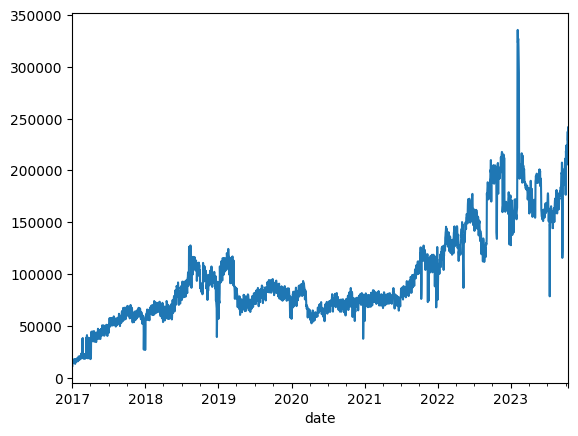

In [ ]:
artist_daily_streams.plot()

In [ ]:
ads = artist_daily_streams/100000

Next, we split the data to a training and testing set.
- For simplicity, the test set is our target prediction period `2022-10-01` to `2022-12-31`
- The training set could be set as the period between `2021-10-01` to `2022-09-30` (1 year)

In [ ]:
data = pd.DataFrame(ads)
data

,streams
date,
2017-01-01,0.11341
2017-01-02,0.13923
2017-01-03,0.16650
2017-01-04,0.17398
2017-01-05,0.16691
...,...
2023-10-11,2.31772
2023-10-12,2.37479
2023-10-13,2.28822


In [ ]:
#split dataset to training and test sets
train_df = data[train_start:train_end]
test_df = data[test_start:test_end]

Text(0, 0.5, 'Streams x 100K')

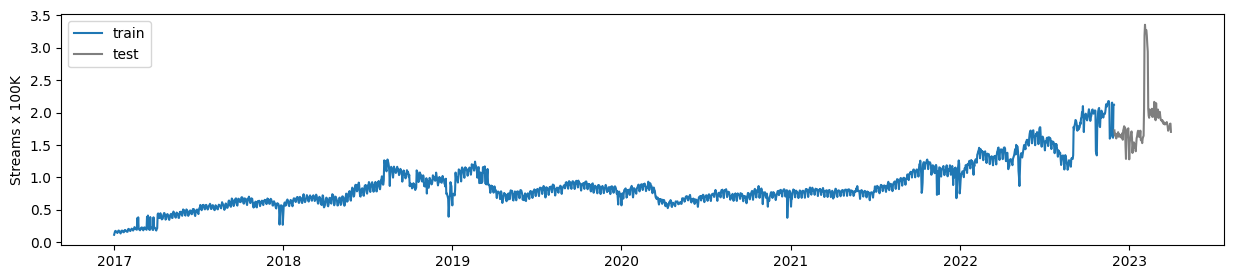

In [ ]:
# Plot the training and testing period
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.legend()
plt.ylabel("Streams x 100K")

## 3. Define error measures

Error measures are important to accurately assess the performance of a forecast. These are 3 most commonly used error measures:

- **Root Mean Squared Error (RMSE)**  is a measure of the average difference between the predicted values and the actual values in a time series. It is calculated as the square root of the average of the squared differences between the predicted and actual values. RMSE is a popular metric because it places greater emphasis on large errors and is useful for evaluating models that are sensitive to outliers.

- **Mean Absolute Error (MAE)** measures the average absolute difference between the predicted values and the actual values in a time series. MAE is less sensitive to outliers than RMSE, and it is useful for evaluating models that do not exhibit a large variance in the errors.

- **Mean Absolute Percentage Error (MAPE)** is a measure of the average percentage difference between the predicted values and the actual values in a time series. MAPE is useful when evaluating models that are sensitive to percentage errors, such as those that predict sales or revenue. However, MAPE is sensitive to zero values in the actual data, and it can be misleading if the actual values are close to zero.


We create a helper function to compute and show all 3 of these errors.



MAPE often used in sales. Unfortunately sensitive to things close to zero.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def show_errors(y_true, y_pred):
    return pd.DataFrame({'RMSE': root_mean_squared_error(y_true,y_pred),\
                                            'MAE':mean_absolute_error(y_true,y_pred),\
                                            'MAPE': mean_absolute_percentage_error(y_true,y_pred)}, index=[0])

In [ ]:
# Test with small sample data
test_actual = [2,4,6]
test_forecast = [1,2,3]
show_errors(test_actual,test_forecast)

,RMSE,MAE,MAPE
0,2.160247,2.0,50.0


## 4. Forecasting methods - Algorithmic approaches

Note: This approach will not work with just our initial training data alone (and thats not how its used in the industry!).

Here in our notebook, we can assume that the test set is **streamed** on a daily basis, i.e. new data comes in daily and the past day's data can be used in the training set for next day's forecast.

If you want to see how these would look like had we been considering a **static** training set, you may view this [blog post](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/)

### 4.1. Previous value (Naive) Approach
*The simplest forecast--the previous available value is the forecast value.*


To simulate a naive forecast that takes in incoming data from test set, shift the data 1 day to the right

In [ ]:
forecast_df = data.shift(1)[test_start:test_end]
forecast_df

,streams
date,
2022-11-30,2.12130
2022-12-01,1.72525
2022-12-02,1.64657
2022-12-03,1.64015
2022-12-04,1.67398
...,...
2023-03-28,1.74467
2023-03-29,1.77921
2023-03-30,1.77957


Text(0, 0.5, 'Streams x 100K')

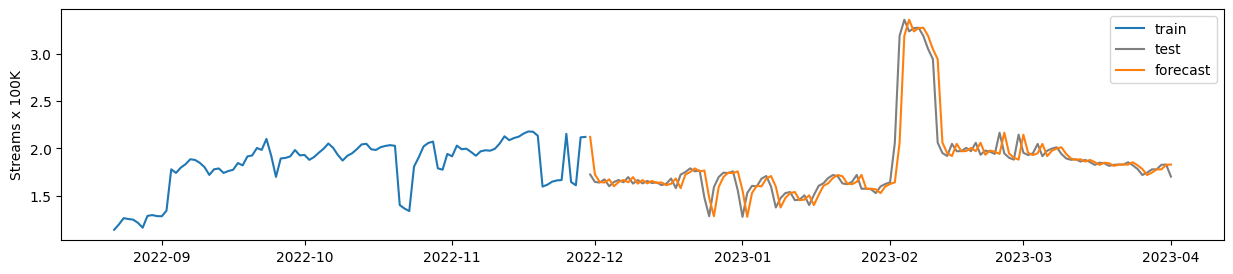

In [ ]:
# plot the forecast results
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'].tail(100), color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'].values,forecast_df['streams'].values)

,RMSE,MAE,MAPE
0,0.167455,0.086519,4.630589


RMSE MAE, 0.04... 4,000 streams. prediction is off by 4k streams

MAPE is 3%. Forecast is off by 3%.

this is barely an algorithm. we can try to do better than this.

Modification: Previous-week (D-7) value

let's get last week's data.

In [ ]:
# shift the data 7 day to the right
forecast_df = data.shift(7)[test_start:test_end]

Text(0, 0.5, 'Streams x 100K')

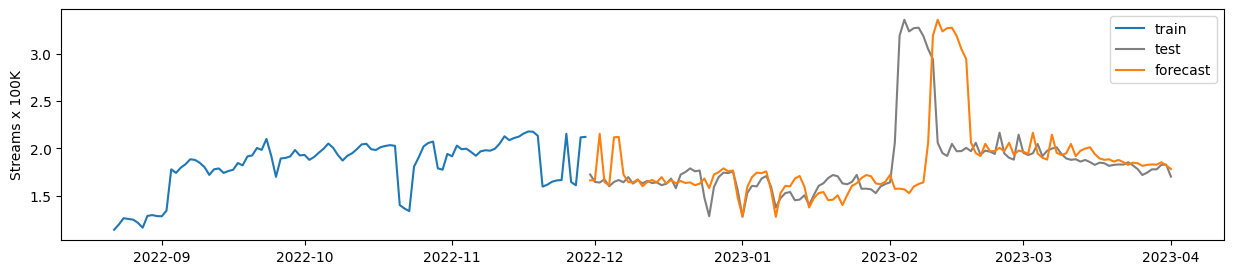

In [ ]:
# plot the forecast
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'].tail(100), color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,0.492222,0.24266,11.160583


### 4.2. Windowed Average Approach
*The average over the X recent days is the forecast value*

To simulate a windowed forecast that takes in incoming data from test set, use the `pd.rolling` grouper and pass the mean method and shift 1 day ahead to match target forecast date


In [ ]:
# Set window to 7 days
WINDOW = 7 #rolling 7-day window
forecast_df = data.rolling(WINDOW).mean().shift(1)[test_start:test_end]#and get the average. we need to also do a shift, to match the desired forecast period
forecast_df

,streams
date,
2022-11-30,1.854054
2022-12-01,1.862996
2022-12-02,1.860127
2022-12-03,1.786703
2022-12-04,1.790827
...,...
2023-03-28,1.797534
2023-03-29,1.790143
2023-03-30,1.783056


Text(0, 0.5, 'Streams x 100K')

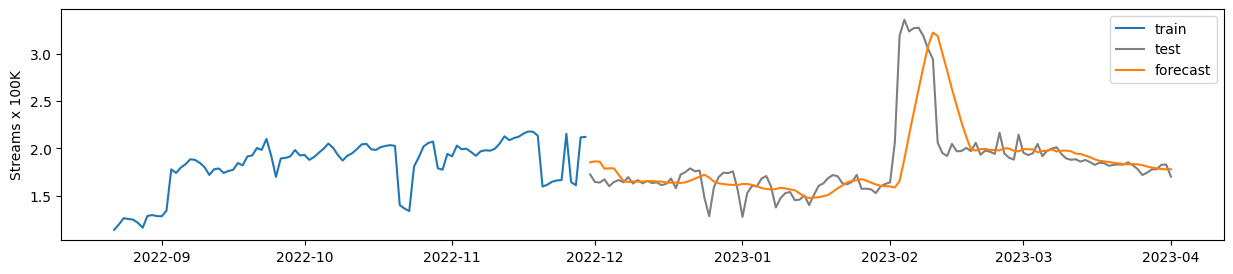

In [ ]:
# plot the forecast
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'].tail(100), color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,0.315427,0.156593,7.545173


### 2.3. Exponential Moving Average Approach
*The weighted average over the most recent days is the forecast value*, where the weights are given by the following formula as set by a smoothing factor $\alpha$

![](https://miro.medium.com/max/1256/1*gzC8tdlwaLM3Y1tiaM3xzw.png)

 Larger $\alpha$ values will assign larger weights to more recent dates.

To simulate an EMA  forecast that takes in incoming data from test set, use the `pd.rolling grouper` and pass the mean method

In [ ]:
# Set alpha to 0.7, i.e. 70% of the forecast will come from the most recent data point
ALPHA = 0.7
forecast_df = data.ewm(alpha=ALPHA).mean().shift(1)[test_start:test_end]#call .ewm

Text(0, 0.5, 'Streams x 100K')

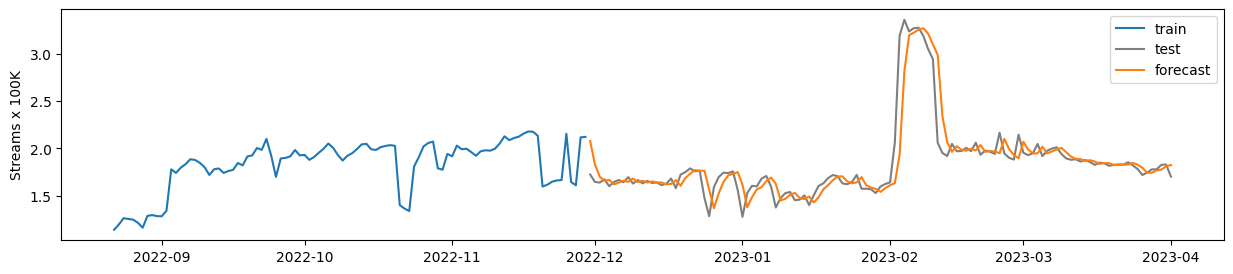

In [ ]:
# plot the forecast results
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'].tail(100), color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,0.185298,0.094716,4.996543


## 5. Forecasting methods - Trend and Seasonality Approaches
One example of a forecasting method that takes trend and seasonality into account is the Holt-Winters method, which uses exponential averages over components. The **Holt-Winters seasonal method** comprises the forecast equation and three smoothing equations

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/01/eq.png)

The method implemented in statsmodels automatically computes for the required parameters.

For this approach, we use a static training period since it is capable of generating forecasts with variability

➿
use expotional average over the components

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

We generate the forecast by calling the fitted model to generate values for every required timestep.
For this example , we tune the model one-time, and only on the initial train data

In [ ]:
# specify fit for weekly (d=7) seasonal cycles
# assume additive combinations of component
model_fit = ExponentialSmoothing(train_df['streams'],seasonal_periods=7 ,trend='add', seasonal='add').fit() #trend is to add. can also multiply but not recommended
forecast_df = pd.DataFrame(model_fit.forecast(len(test_df)).values, index=test_df.index,\
                           columns=['streams'])

Text(0, 0.5, 'Streams x 100K')

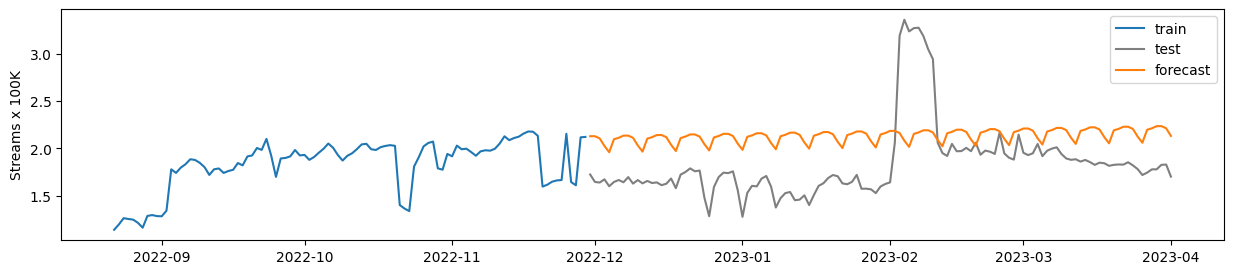

In [ ]:
# plot the forecast results
fig = plt.figure(figsize=(15,3))

plt.plot(train_df['streams'].tail(100), color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,0.485657,0.428601,23.850158


## 5. Forecasting methods - Stochastic Approach
A popular and frequently used **stochastic** (i.e. probabilistic "randomness" based models) time series model is the **ARIMA model**.

It assumes that the time-series is linear and follows a particular known statistical distribution, such as the normal distribution, and has subclass of other models such as the Autoregressive (AR) model, the Moving average (MA) model, and the Autoregressive Moving Average (ARMA) model of which the ARIMA model was based on.

An *ARIMA model* is usually written as ARIMA (p,d,q)

![](https://miro.medium.com/max/875/1*J1cOKMRU17nr71T-Xx6_HQ.png)

where:

p = The order of the Autoregressive part of the model

d= The degree of first differencing in our model

q = The order of the Moving average part of the model

**How do we get the optimal values for these parameters?**

**p**: Examine the PACF plot to determine the value of p, the order of the autoregressive part of the model. Look for the **first lag that is statistically significant (above the shading)** and note the corresponding lag number on the x-axis. This will be your initial estimate for p.

**q**: Examine the ACF plot to determine the value of q, the number of lagged error terms to include in the model. Look for the **first lag that is statistically significant (above the shading)** and note the corresponding lag number on the x-axis. This will be your initial estimate for q.

**d**: If time series is stationary, set d=0 .When time series is not stationary, wsually d =  1 or 2 is sufficient

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

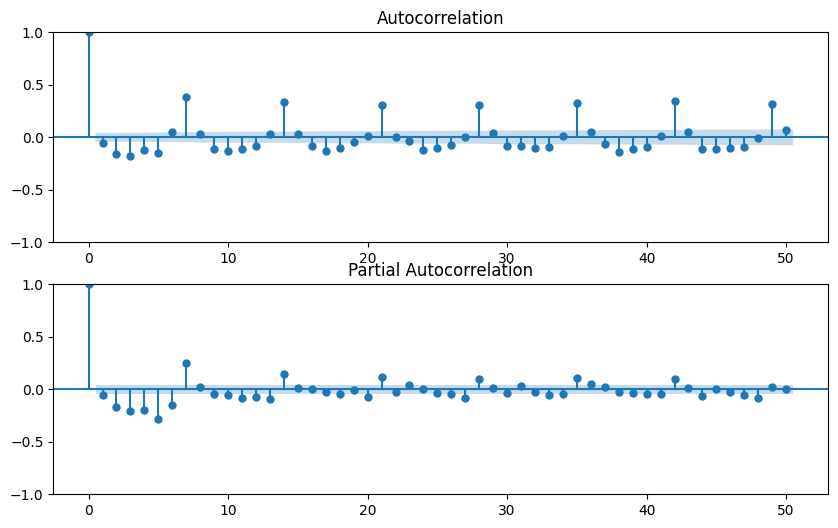

In [ ]:
# ACF, PACF plots
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

acf = plot_acf(train_df['streams'].interpolate().diff()[1:], lags=50, ax=ax1)
pacf = plot_pacf(train_df['streams'].interpolate().diff()[1:], lags=50, ax=ax2)

From the ACF, it seems like the model needs to take in 7 MA terms (i.e. moving averages up to 7 days), i.e. q=7

From the PACF, it is likely that a model with up to 7 AR terms also would be best to use, i.e. p=7

We set d = 1 to stationarize the train set

In [ ]:
model = ARIMA(train_df, order=(7, 1, 7))
model_fit = model.fit()
train_fit_df = pd.DataFrame(model_fit.fittedvalues, columns=['streams'])

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0, 0.5, 'Streams x 100K')

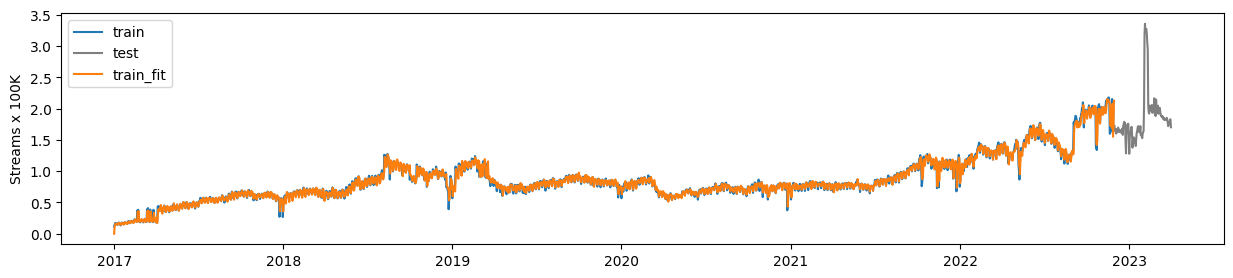

In [ ]:
#plot the fitted training data
fig = plt.figure(figsize=(15,3))

plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(train_fit_df['streams'], color='C1', label='train_fit')
plt.legend()
plt.ylabel("Streams x 100K")

We generate the forecast by calling the fitted model to generate values for every required timestep.
For this example , we tune the model one-time, and only on the initial train data

In [ ]:
#dynamic = True toggles use of preceding forecast value with the model fit values to get the next forecast value
forecast_df = pd.DataFrame(model_fit.forecast(len(test_df),dynamic=True).values, index=test_df.index,\
                           columns=['streams'])

Text(0, 0.5, 'Streams x 100K')

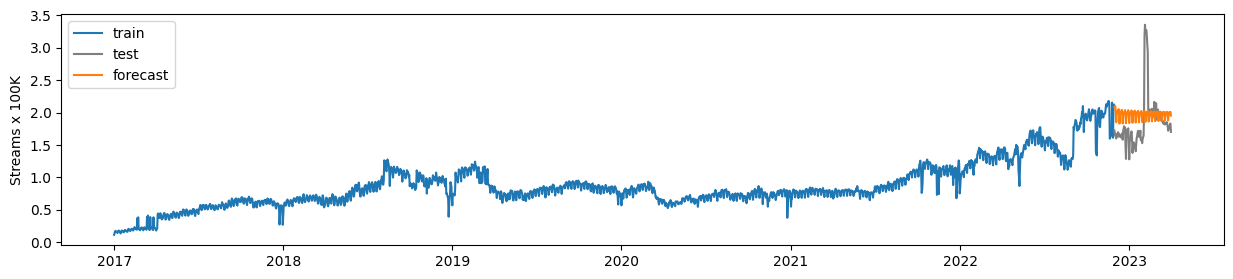

In [ ]:
# plot the forecast results
fig = plt.figure(figsize=(15,3))

plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,0.418848,0.3089,16.59098


## 5. Forecasting methods - Neural Network Approach

Neural networks can be used to forecast time series. Some of the popular algorithms are recurrent neural networks (RNNs) and convolutional neural networks (CNNs). These are standard models but the learning curve to understand the parameters that need to be tuned can be quite steep for beginners.

[NeuralProphet](https://neuralprophet.com/) is an easy to learn framework and a good entry point to neural network forecasting. NeuralProphet is built on PyTorch and combines Neural Network and traditional time-series algorithms, inspired by [Facebook Prophet](https://github.com/facebook/prophet) and [AR-Net](https://github.com/ourownstory/AR-Net).

This relatively simple-to-train model outperforms its predecessor Facebook Prophet in a variety of use cases. See some results [here](https://towardsdatascience.com/prophet-vs-neuralprophet-fc717ab7a9d8)

In [ ]:
#uncomment if neuralprophet doesn't work below
# !pip uninstall -y prophet torchaudio torchtext torchvision torchdata

In [ ]:
from neuralprophet import NeuralProphet

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning:

Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?



In [ ]:
# Create Prophet model
model = NeuralProphet()
# model = NeuralProphet(batch_size=232)
# Rename the columns to fit Prophet's requirements
input_df = train_df.copy().reset_index()
input_df = input_df.rename(columns={'date': 'ds', 'streams': 'y'})

# Fit model to data
model.fit(input_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.954% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.co

Finding best initial lr:   0%|          | 0/233 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,1.197846,1.434776,0.324239,0.0,0
1,1.142999,1.370620,0.299676,0.0,1
2,1.068015,1.284411,0.267725,0.0,2
3,0.976348,1.185478,0.230347,0.0,3
4,0.854888,1.044259,0.182361,0.0,4
...,...,...,...,...,...
149,0.068560,0.096652,0.001784,0.0,149
150,0.068719,0.096525,0.001784,0.0,150
151,0.068664,0.095757,0.001780,0.0,151
152,0.068834,0.096181,0.001787,0.0,152


In [ ]:
# Generate future predictions
future = model.make_future_dataframe(input_df, periods=len(test_df))

# Make predictions
forecast = model.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.954% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.187% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.187% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
0,2022-11-30,None,1.858982,1.816609,0.011880,0.030493
1,2022-12-01,None,1.858703,1.818461,0.008139,0.032103
2,2022-12-02,None,1.836780,1.820314,0.004210,0.012257
3,2022-12-03,None,1.792577,1.822166,0.000103,-0.029692
4,2022-12-04,None,1.747490,1.824018,-0.004154,-0.072374
...,...,...,...,...,...,...
118,2023-03-28,None,2.033852,2.035179,-0.028039,0.026713
119,2023-03-29,None,2.036809,2.037031,-0.030720,0.030498
120,2023-03-30,None,2.037611,2.038883,-0.033389,0.032116
121,2023-03-31,None,2.016841,2.040736,-0.036046,0.012152


In [ ]:
forecast_df = forecast[['ds','yhat1']].rename(columns={'ds':'date','yhat1':'streams'}).set_index('date')
forecast_df

,streams
date,
2022-11-30,1.858982
2022-12-01,1.858703
2022-12-02,1.836780
2022-12-03,1.792577
2022-12-04,1.747490
...,...
2023-03-28,2.033852
2023-03-29,2.036809
2023-03-30,2.037611


Text(0, 0.5, 'Streams x 100K')

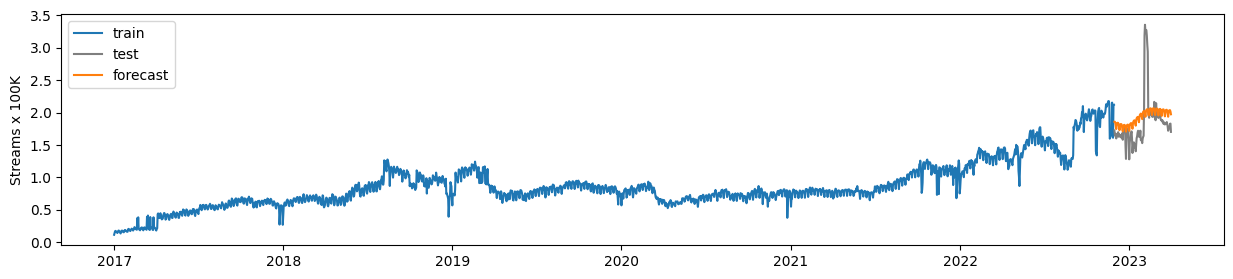

In [ ]:
# plot the forecast results
fig = plt.figure(figsize=(15,3))

plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [ ]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,0.365614,0.247368,12.794366
